# Урок 6. Градиентный бустинг

In [18]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib
import matplotlib.pyplot as plt
from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [19]:
from sklearn.datasets import load_diabetes

In [20]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [21]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [22]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [23]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Тогда сдвиг будет равен $s =- L'(y, z)$. 

In [24]:
def bias(y, z):
    return - 2 * (z - y)

Реализуем функцию обучения градиентного бустинга.

In [25]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [31]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [32]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

In [33]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 1095
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 4845


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [40]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

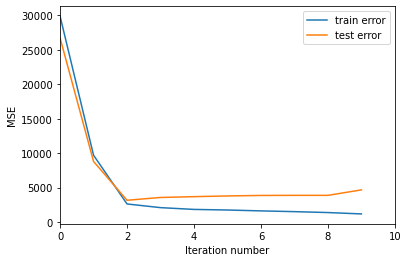

In [41]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [42]:
n_trees = 25
coefs = [1] * n_trees

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [43]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 413
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 5289


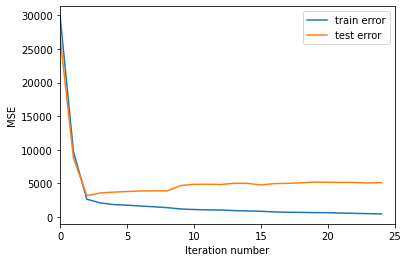

In [44]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [45]:
eta = 0.05

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [46]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2104
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 2993


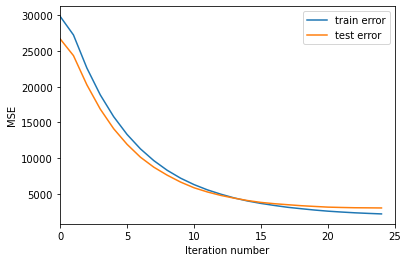

In [47]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.005.

In [48]:
eta = 0.005

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [49]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.005 на тренировочной выборке: 19368
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.005 на тестовой выборке: 17331


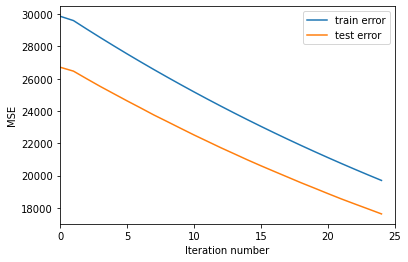

In [50]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.05 и попробуем увеличить глубину деревьев

In [51]:
eta = 0.05
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [52]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 889
Ошибка алгоритма из 25 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 3614


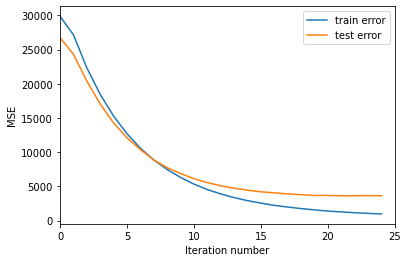

In [53]:
get_error_plot(n_trees, train_errors, test_errors)

In [260]:
#влияние на обучение максимальной глубины деревьев при постоянном количестве деревьев 
#и коэффициенте скорости обучения - eta
n_trees = 15
coefs = [1] * n_trees
eta = 0.1
max_depth = [3, 5, 7]

def error_max_depth_plot():
    for max_depth_coef in max_depth:
        trees, train_errors, test_errors = gb_fit(n_trees,
                                                  max_depth_coef,
                                                  X_train, 
                                                  X_test, 
                                                  y_train,
                                                  y_test,
                                                  coefs,
                                                  eta
                                                 )
#         fig = plt.figure(figsize=(15,8))
        plt.xlabel('Iteration number')
        plt.ylabel('MSE')
        plt.xlim(0, n_trees)
        plt.plot(list(range(n_trees)), train_errors, label=f'train error with max_depth {max_depth_coef}')
        plt.plot(list(range(n_trees)), test_errors, label=f'test error with max_depth {max_depth_coef}')
    plt.legend(loc='upper right')
    plt.show()

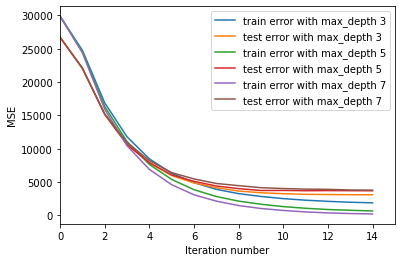

In [261]:
error_max_depth_plot()

Вывод: изменяя один параметр - хорошую модель не получить)))

In [258]:
#влияние на обучение при разных значениях скорости обучения - eta и постояном кол-ве
#максимальной глубины деревьев и постоянном количестве деревьев 
n_trees = 15
coefs = [1] * n_trees
eta = [0.01, 0.05, 0.1]
max_depth = 5

def error_eta_plot():
    for eta_coef in eta:
        trees, train_errors, test_errors = gb_fit(n_trees,
                                                  max_depth,
                                                  X_train, 
                                                  X_test, 
                                                  y_train,
                                                  y_test,
                                                  coefs,
                                                  eta_coef
                                                 )
#         fig = plt.figure(figsize=(15,8))
        plt.xlabel('Iteration number')
        plt.ylabel('MSE')
        plt.xlim(0, n_trees)
        plt.plot(list(range(n_trees)), train_errors, label=f'train error with eta {eta_coef}')
        plt.plot(list(range(n_trees)), test_errors, label=f'test error with eta {eta_coef}')
    plt.legend(loc='upper right')
    plt.show()

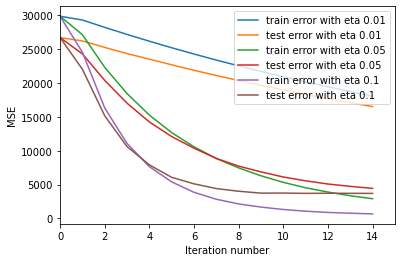

In [259]:
error_eta_plot()

Выводы: точность предсказаний при eta = 0.1 выше, чем при более низких значениях этого коэффициента. И конечно же, изменяя один параметр - хорошую модель не получить)

Посмотрим на разные варианты сочетаний коэффициентов eta и max_depth и n_trees

In [262]:
from tqdm import tqdm as tq
import time

In [288]:
n_trees = [15, 20, 30]
eta = [0.05, 0.1]
max_depth = [5, 7, 9]
result_list = []

In [289]:
for n_trees_coef in tq(n_trees):    
    for eta_coef in tq(eta):
        for max_depth_coef in tq(max_depth):
            trees, train_errors, test_errors = gb_fit(n_trees_coef,
                                                      max_depth_coef,
                                                      X_train,
                                                      X_test,
                                                      y_train,
                                                      y_test,
                                                      coefs,
                                                      eta_coef
                                                     )
            result_list.append([n_trees_coef, eta_coef, max_depth_coef, train_errors, test_errors])

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:03<00:07,  3.55s/it]

 67%|████████████████████████████████████████████████████████                            | 2/3 [00:07<00:03,  3.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.68s/it]

 50%|██████████████████████████████████████████                                          | 1/2 [00:11<00:11, 11.05s/it]

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████                                                        | 1/3 [00:03<00:07,  3.71s/it]

 67%|███████████████████████████

In [290]:
result_processed = []
for n_trees_coef, eta_coef, max_depth_coef, train_errors, test_errors in result_list:
    result_processed.append([n_trees_coef, eta_coef, max_depth_coef, min(train_errors), min(test_errors)])

In [294]:
for n_trees_coef, eta_coef, max_depth_coef, train_errors, test_errors in np.array(result_processed):
    if test_errors == np.array(result_processed)[:,4].min():
        print(f'Оптимальные параметры: кол-во деревьев={n_trees_coef}, скорость обучения={eta_coef}, глубина деревьев={max_depth_coef}, ошибка на трэйне={train_errors}, ошибка на тесте={test_errors}')


Оптимальные параметры: кол-во деревьев=15.0, скорость обучения=0.1, глубина деревьев=5.0, ошибка на трэйне=667.1127414066174, ошибка на тесте=3697.8813137987263
Оптимальные параметры: кол-во деревьев=20.0, скорость обучения=0.1, глубина деревьев=5.0, ошибка на трэйне=591.1920582485749, ошибка на тесте=3697.8813137987263
Оптимальные параметры: кол-во деревьев=30.0, скорость обучения=0.1, глубина деревьев=5.0, ошибка на трэйне=591.1920582485749, ошибка на тесте=3697.8813137987263


## Домашние задания

1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров. Подобрать оптимальные значения этих гиперпараметров.

2. (\*) Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

3. (\*) Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии). Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.